In [1]:
!pip install pybaseball
import altair as alt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pc
from pybaseball import statcast
import pybaseball
import pandas as pd
pd.set_option('display.max_columns', 100)

  Stored in directory: /root/.cache/pip/wheels/ec/07/ea/c76916b911a2f060d1dfa2e900460e6b5004ef334ff83cb419
Successfully built pybaseball


In [2]:
#@title データ取得の初期値
#First = "ichiro" #@param {type:"string"}
#Last = "suzuki" #@param {type:"string"}

#player_id = playerid_lookup(Last, First)["key_mlbam"].values[0]

# データ取得期間を決定
start_date = '2018-04-01' #@param {type:"date"}
end_date = '2018-11-30' #@param {type:"date"}

# 投手のデータを取得
data = statcast(start_dt=start_date, end_dt=end_date)
data['pfx_x'] = data['pfx_x']*30.48
data['pfx_z'] = data['pfx_z']*30.48
data['release_pos_x'] = data['release_pos_x']*30.48
data['release_pos_z'] = data['release_pos_z']*30.48
data['plate_x'] = data['plate_x']*30.48
data['plate_z'] = data['plate_z']*30.48
data['sz_top'] = data['sz_top']*30.48
data['sz_bot'] = data['sz_bot']*30.48
print(data.shape)


This is a large query, it may take a moment to complete
Completed sub-query from 2018-04-01 to 2018-04-06
Completed sub-query from 2018-04-07 to 2018-04-12
Completed sub-query from 2018-04-13 to 2018-04-18
Completed sub-query from 2018-04-19 to 2018-04-24
Completed sub-query from 2018-04-25 to 2018-04-30
Completed sub-query from 2018-05-01 to 2018-05-06
Completed sub-query from 2018-05-07 to 2018-05-12
Completed sub-query from 2018-05-13 to 2018-05-18
Completed sub-query from 2018-05-19 to 2018-05-24
Completed sub-query from 2018-05-25 to 2018-05-30
Completed sub-query from 2018-05-31 to 2018-06-05
Completed sub-query from 2018-06-06 to 2018-06-11
Completed sub-query from 2018-06-12 to 2018-06-17
Completed sub-query from 2018-06-18 to 2018-06-23
Completed sub-query from 2018-06-24 to 2018-06-29
Completed sub-query from 2018-06-30 to 2018-07-05
Completed sub-query from 2018-07-06 to 2018-07-11
Completed sub-query from 2018-07-12 to 2018-07-17
Completed sub-query from 2018-07-18 to 2018-

In [0]:
# 見送った投球のデータ
send_off_data = data[(data['description']=='called_strike')|(data['description']=='ball')][['description', 'plate_x', 'plate_z']].dropna()

# bins
bins = 15 #@param {type:'integer'}
x_bin = np.linspace(-60, 60, bins)
z_bin = np.linspace(0, 160, bins)
# 結果を表示するコース
course_data, x_bin, z_bin = np.histogram2d(send_off_data['plate_x'].values, send_off_data['plate_z'].values, bins=[x_bin, z_bin])

# 0で割らないための処理
course_data[course_data==0] = 1

# called_strikeなコース
called_strike_plate = send_off_data.loc[send_off_data['description']=='called_strike'][['plate_x', 'plate_z']].values
called_strike_course_data, _, _ = np.histogram2d(called_strike_plate[:, 0], called_strike_plate[:, 1], bins=[x_bin, z_bin])

# コース別打率
strike_and_ball_course_data = called_strike_course_data/course_data

# Top and Bottom
#sz_top_highest_freq = batting_data['sz_top'].value_counts().index[0]
#sz_bot_highest_freq = batting_data['sz_bot'].value_counts().index[0]


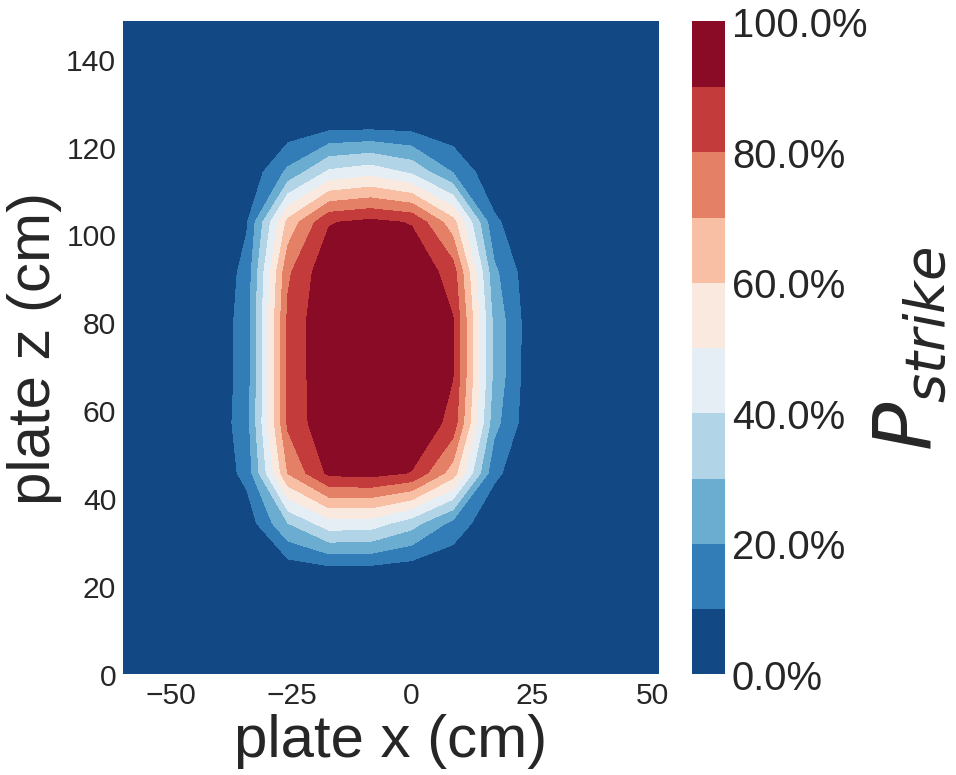

In [4]:
# ストライクゾーンの可視化
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
#cont = ax.contour(x_bin[:-1], z_bin[:-1], strike_and_ball_course_data, colors='k')
cntr = ax.contourf(x_bin[:-1], z_bin[:-1], strike_and_ball_course_data, cmap='RdBu_r', levels=np.arange(0, 1.1, 0.1))
#cont.clabel(fmt='%1.1f', fontsize=14)

cbar = fig.colorbar(cntr, ax=ax)
ax.set_xlabel("plate x (cm)", fontsize = 60)
ax.set_ylabel("plate z (cm)", fontsize = 60)
ax.tick_params(labelsize=30)
ax.grid()
cbar.set_label("$P_{strike}$", size=80)
cbar.set_ticklabels(["{:.4}%".format(k*100) for k in cbar.get_ticks()])
cbar.ax.tick_params(labelsize=40)

plt.show()

# 分析例:吉田輝星と似たストレートを投げる投手を探す．
2018年夏の甲子園を沸かせた吉田輝星投手のストレートは特徴的であることが指摘されています．![代替テキスト](https://jp-baseballgeeks.s3.amazonaws.com/wp-content/uploads/2018/08/9234dd1a6d52a437ea3cc6a4c9488469.jpg)

具体的には縦53cm，横10cmらしいです．これがどの程度効果的なのかは分かりませんが，2018シーズンのMLBで似たようなストレートを投げる投手を探してみたいと思います．

「似ている」の定義

* 右投手のストレートに限定
* 球速帯が142～152km/h程度
* 平均変化量が縦:50～55cm，横:5～15cm

とりあえずこれくらいでいきます．投球したストレート全体の内，この条件を満たすストレートの割合が最も高い選手を決定する．

In [5]:
data.head()

index pitch_type  game_date  release_speed  release_pos_x  release_pos_z  \
0      0         SL 2018-10-28           84.0      93.113352     160.196784   
1      1         FF 2018-10-28           95.3      96.502728     167.673528   
2      2         FF 2018-10-28           96.4      93.658944     168.715944   
3      3         CH 2018-10-28           86.6      94.545912     151.851360   
4      4         SL 2018-10-28           78.5     100.812600     157.377384   

  player_name    batter   pitcher     events      description  spin_dir  \
0  Chris Sale  592518.0  519242.0  strikeout  swinging_strike       NaN   
1  Chris Sale  592518.0  519242.0        NaN             ball       NaN   
2  Chris Sale  592518.0  519242.0        NaN             foul       NaN   
3  Chris Sale  592518.0  519242.0        NaN  swinging_strike       NaN   
4  Chris Sale  571771.0  519242.0  strikeout  swinging_strike       NaN   

   spin_rate_deprecated  break_angle_deprecated  break_length_deprecated  \
0                   NaN                     NaN                      NaN   
1                   NaN                     NaN                      NaN   
2                   NaN                     NaN                      NaN   
3                   NaN                     NaN                      NaN   
4                   NaN                     NaN                      NaN   

   zone                                        des game_type stand p_throws  \
0  13.0      Manny Machado strikes out swinging.           W     R        L   
1  12.0                                        NaN         W     R        L   
2   3.0                                        NaN         W     R        L   
3  13.0                                        NaN         W     R        L   
4   4.0  Enrique Hernandez strikes out swinging.           W     R        L   

  home_team away_team type  hit_location bb_type  balls  strikes  game_year  \
0       LAD       BOS    S           2.0     NaN    1.0      2.0     2018.0   
1       LAD       BOS    B           NaN     NaN    0.0      2.0     2018.0   
2       LAD       BOS    S           NaN     NaN    0.0      1.0     2018.0   
3       LAD       BOS    S           NaN     NaN    0.0      0.0     2018.0   
4       LAD       BOS    S           2.0     NaN    3.0      2.0     2018.0   

       pfx_x      pfx_z    plate_x     plate_z  on_3b  on_2b  on_1b  \
0 -41.132760  -7.872984 -51.651408   27.560016    NaN    NaN    NaN   
1  25.350216  38.410896   4.934712  136.605264    NaN    NaN    NaN   
2  32.068008  31.565088  19.028664  109.304328    NaN    NaN    NaN   
3  46.482000  -0.576072  -3.020568   42.345864    NaN    NaN    NaN   
4 -39.111936  -7.723632 -12.521184   83.588352    NaN    NaN    NaN   

   outs_when_up  inning inning_topbot  hc_x  hc_y  tfs_deprecated  \
0           2.0     9.0           Bot   NaN   NaN             NaN   
1           2.0     9.0           Bot   NaN   NaN             NaN   
2           2.0     9.0           Bot   NaN   NaN             NaN   
3           2.0     9.0           Bot   NaN   NaN             NaN   
4           1.0     9.0           Bot   NaN   NaN             NaN   

   tfs_zulu_deprecated  fielder_2  umpire          sv_id      vx0       vy0  \
0                  NaN   543877.0     NaN  181029_031720  -8.2873 -121.9379   
1                  NaN   543877.0     NaN  181029_031659  -9.7012 -138.3907   
2                  NaN   543877.0     NaN  181029_031631  -8.8528 -140.1200   
3                  NaN   543877.0     NaN  181029_031609 -10.6970 -125.6917   
4                  NaN   543877.0     NaN  181029_031528  -5.6510 -114.0046   

      vz0       ax       ay       az      sz_top     sz_bot  hit_distance_sc  \
0 -3.0512 -11.3466  26.6494 -34.2878  106.375200  48.798480              NaN   
1  0.2123  12.8837  33.3199 -16.4847  114.007392  52.407312              NaN   
2 -1.9552  15.7257  29.9039 -18.3468  106.375200  48.798480              NaN   
3 -2.2993  18.2514  25.2660 -32.1

In [0]:
# 右投手のみ条件
right_throw = (data["p_throws"]=="R")

# ストレート
straight = (data["pitch_type"]=="FF")

# 右投手のストレートのデータセット
right_straight_data = data[right_throw & straight]

# 球速帯142～152km/h程度
vel_min = 142/1.60934
vel_max = 152/1.60934
vel_condition = (right_straight_data['release_speed'] <= vel_max) & (right_straight_data['release_speed'] >= vel_min)

# ストレートの変化量縦:50～55cm，横:5～15cm
vertical_min, vertical_max = 50, 55
horizontal_min, horizontal_max = -15, -5
horizontal_condition = (right_straight_data['pfx_x'] <= horizontal_max) & (right_straight_data['pfx_x'] >= horizontal_min)
vertical_condition = (right_straight_data['pfx_z'] <= vertical_max) & (right_straight_data['pfx_z'] >= vertical_min)

In [58]:
right_straight_data["like_yoshida"] = (vel_condition & horizontal_condition & vertical_condition)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
player_like_yoshida = right_straight_data.pivot_table(index="player_name", aggfunc="mean")['like_yoshida']

In [0]:
player_name_index = np.array(list(player_like_yoshida.index))

# 吉田らしさが0.15を超える選手の名前を確認
player_names = player_name_index[(player_like_yoshida.values>0.15)]

In [88]:
print(player_names)

['Adam Plutko' 'Danny Farquhar' 'Fernando Salas' 'Javy Guerra'
 'Kevin Jepsen' 'Nick Gardewine' 'Tyler Clippard']


吉田らしいストレートを投げる割合の高い選手を抽出できました．次に，pfxのデータを可視化したいと思います．

# 可視化の関数
なぜか上手くいかない

In [0]:
def visualize_pfx(player_name):
    pitch_data = data[data["player_name"]==player_name]
    alt.Chart(pitch_data).mark_point(size=60).encode(
        x=alt.X('pfx_x', title='Pitch fx: x (cm)'),
        y=alt.Y('pfx_z', title='Pitch fx: z (cm)'),
        color='picth_name',
        tooltip=['player_name', 'pitch_name', 'events']
    ).interactive()

# Adam Plutko

In [138]:
pitch_data = data[data["player_name"]==player_names[0]]
alt.Chart(pitch_data).mark_point(size=20).encode(
    x=alt.X('pfx_x', title='Pitch fx: x (cm)'),
    y=alt.Y('pfx_z', title='Pitch fx: z (cm)'),
    color='pitch_name',
    tooltip=['player_name', 'pitch_name', 'events']
).properties(height=400, width=500).interactive()

Output hidden; open in https://colab.research.google.com to view.

# Danny Farquhar

In [137]:
pitch_data = data[data["player_name"]==player_names[1]]
alt.Chart(pitch_data).mark_point(size=20).encode(
    x=alt.X('pfx_x', title='Pitch fx: x (cm)'),
    y=alt.Y('pfx_z', title='Pitch fx: z (cm)'),
    color='pitch_name',
    tooltip=['player_name', 'pitch_name', 'release_speed', 'events']
).properties(height=400, width=500).interactive()

Chart({
  data:         index pitch_type  game_date  release_speed  release_pos_x  \
  647633  16542         CH 2018-04-20           85.9     -67.949064   
  647634  16551         CU 2018-04-20           73.9     -57.402984   
  647635  16575         FF 2018-04-20           92.5     -62.017656   
  647636  16579         CH 2018-04-20           86.4     -60.783216   
  647637  16596         FF 2018-04-20           93.0     -54.900576   
  647638  16615         FF 2018-04-20           93.2     -59.567064   
  647639  16637         CH 2018-04-20           86.3     -63.090552   
  647640  16643         FF 2018-04-20           93.2     -61.069728   
  647641  16666         CH 2018-04-20           85.1     -62.267592   
  647642  16672         CH 2018-04-20           84.4     -66.812160   
  647643  16694         FF 2018-04-20           93.2     -60.682632   
  647644  16719         CH 2018-04-20           85.9     -66.202560   
  647645  16725         FF 2018-04-20           92.1     -57.375552   
  647646  16744         FF 2018-04-20           92.9     -65.961768   
  647647  16767         FF 2018-04-20           92.1     -59.877960   
  655367    359         CU 2018-04-18           74.1     -65.867280   
  655368    364         CH 2018-04-18           84.5     -73.868280   
  655369    366         FF 2018-04-18           92.6     -64.160400   
  663661   9982         FF 2018-04-16           93.2     -67.260216   
  663662   9995         CH 2018-04-16           86.0     -67.869816   
  663663  10000         CH 2018-04-16           87.3     -69.704712   
  663664  10010         CU 2018-04-16           75.8     -56.601360   
  663665  10022         FF 2018-04-16           92.3     -56.464200   
  663666  10025         FF 2018-04-16           91.2     -57.470040   
  686498  12105         FF 2018-04-09           91.2     -49.874424   
  686499  12118         FF 2018-04-09           91.9     -49.027080   
  686500  12121         CH 2018-04-09           84.5     -57.652920   
  686501  12135         FF 2018-04-09           91.2     -47.844456   
  686502  12148         FF 2018-04-09           91.3     -48.274224   
  686503  12163         FF 2018-04-09           93.0     -57.863232   
  ...       ...        ...        ...            ...            ...   
  707737   7044         FF 2018-04-04           92.8     -79.217520   
  707738   7066         CU 2018-04-04           75.8     -62.874144   
  707739   7072         CH 2018-04-04           87.6     -73.697592   
  707740   7088         FF 2018-04-04           93.4     -66.964560   
  707741   7092         FF 2018-04-04           91.8     -60.258960   
  707759   7314         FF 2018-04-04           93.3     -74.173080   
  707760   7322         CH 2018-04-04           85.9     -72.140064   
  707761   7337         CH 2018-04-04           87.1     -71.948040   
  707762   7343         FF 2018-04-04           92.4     -72.484488   
  707763   7359         CH 2018-04-04           85.8     -75.325224   
  707764   7367         CH 2018-04-04           85.7     -64.919352   
  707765   7390         FF 2018-04-04           92.8     -64.690752   
  707766   7400         CH 2018-04-04           86.1     -71.417688   
  714853  14192         CH 2018-04-02           85.7     -67.888104   
  714854  14206         FF 2018-04-02           92.8     -67.065144   
  714855  14214         CH 2018-04-02           86.1     -70.838568   
  714856  14229         FF 2018-04-02           92.3     -65.218056   
  714857  14235         CU 2018-04-02           75.8     -66.010536   
  714858  14255         FF 2018-04-02           92.3     -58.689240   
  714876  14467         FF 2018-04-02           92.5     -66.711576   
  714877  14477         CH 2018-04-02           87.0     -69.348096   
  714878  14497         CH 2018-04-02           87.3     -69.985128   
  714879  14506         FF 2018-04-02           93.1     -66.394584   
  714880  14516         FF 2018-04-02           93.8     -62.971680   
  714881  

# Fernando Salas

In [136]:
pitch_data = data[data["player_name"]==player_names[2]]
alt.Chart(pitch_data).mark_point(size=20).encode(
    x=alt.X('pfx_x', title='Pitch fx: x (cm)'),
    y=alt.Y('pfx_z', title='Pitch fx: z (cm)'),
    color='pitch_name',
    tooltip=['player_name', 'pitch_name', 'release_speed', 'events']
).properties(height=400, width=500).interactive()

Chart({
  data:         index pitch_type  game_date  release_speed  release_pos_x  \
  345301    462         FF 2018-07-05           90.3     -18.995136   
  345302    464         CH 2018-07-05           86.4      -5.385816   
  345303    477         FF 2018-07-05           89.0     -15.794736   
  345304    487         FF 2018-07-05           88.6     -16.855440   
  345305    491         KC 2018-07-05           82.2     -22.357080   
  345306    497         KC 2018-07-05           81.2     -21.226272   
  345307    508         KC 2018-07-05           83.0     -23.195280   
  345308    513         CH 2018-07-05           88.0     -21.534120   
  345309    523         FF 2018-07-05           90.7     -20.083272   
  345310    529         CH 2018-07-05           85.8     -17.855184   
  345311    541         FF 2018-07-05           91.6     -16.334232   
  345312    543         CH 2018-07-05           87.3     -12.512040   
  345313    555         CH 2018-07-05           88.6     -12.316968   
  345314    559         FF 2018-07-05           91.0     -16.974312   
  345315    573         FF 2018-07-05           90.8     -17.361408   
  345316    575         CH 2018-07-05           88.2     -12.658344   
  345317    586         CH 2018-07-05           86.1     -15.654528   
  345318    592         FF 2018-07-05           90.5     -18.522696   
  345319    602         FF 2018-07-05           91.7     -17.032224   
  345320    606         FF 2018-07-05           89.1     -16.056864   
  345321    619         CH 2018-07-05           86.7      -8.177784   
  345322    623         FF 2018-07-05           89.8     -13.819632   
  345323    637         KC 2018-07-05           82.0     -18.480024   
  345324    639         FF 2018-07-05           90.6     -24.886920   
  347297   2746         CH 2018-07-04           82.6     -16.434816   
  347298   2756         CH 2018-07-04           87.5     -22.107144   
  347299   2773         KC 2018-07-04           81.0     -24.960072   
  347300   2777         KC 2018-07-04           81.3     -24.396192   
  347301   2794         KC 2018-07-04           80.2     -24.377904   
  347329   3140         FF 2018-07-04           91.3     -24.944832   
  ...       ...        ...        ...            ...            ...   
  713416  13572         CH 2018-04-02           85.8     -18.982944   
  713417  13573         KC 2018-04-02           80.1     -25.892760   
  713431  13587         CH 2018-04-02           86.1      -9.750552   
  713432  13588         FF 2018-04-02           90.1     -22.658832   
  713433  13589         CH 2018-04-02           84.9     -15.087600   
  713434  13590         FF 2018-04-02           88.1     -19.309080   
  713435  13591         CH 2018-04-02           86.0     -12.963144   
  713436  13592         CH 2018-04-02           86.5     -13.255752   
  713437  13593         FF 2018-04-02           90.5     -22.265640   
  713438  13594         CH 2018-04-02           86.8     -15.666720   
  713439  13595         FF 2018-04-02           91.3     -19.415760   
  713440  13596         CH 2018-04-02           85.8     -13.603224   
  713441  13597         CH 2018-04-02           86.2     -18.598896   
  713442  13598         FF 2018-04-02           90.1     -21.735288   
  713443  13599         FF 2018-04-02           90.6     -22.905720   
  713444  13600         CH 2018-04-02           85.0     -13.953744   
  713451  13607         FF 2018-04-02           89.8     -23.472648   
  713452  13608         FF 2018-04-02           90.4     -25.545288   
  713453  13609         FF 2018-04-02           89.6     -25.033224   
  713454  13610         CH 2018-04-02           85.8     -15.572232   
  713455  13611         CH 2018-04-02           85.7     -19.568160   
  713456  13612         FF 2018-04-02           87.9     -27.419808   
  713457  13613         FF 2018-04-02           90.7     -21.180552   
  713458  13614         FF 2018-04-02           89.9     -19.528536   
  713459  

# Javy Guerra

In [135]:
pitch_data = data[data["player_name"]==player_names[3]]
alt.Chart(pitch_data).mark_point(size=20).encode(
    x=alt.X('pfx_x', title='Pitch fx: x (cm)'),
    y=alt.Y('pfx_z', title='Pitch fx: z (cm)'),
    color='pitch_name',
    tooltip=['player_name', 'pitch_name', 'release_speed', 'events']
).properties(height=400, width=500).interactive()

Chart({
  data:         index pitch_type  game_date  release_speed  release_pos_x  \
  16674    5373         SL 2018-09-29           87.1     -16.099536   
  37771   11415         FF 2018-09-24           92.2     -20.644104   
  37772   11426         CU 2018-09-24           78.4     -22.466808   
  37773   11439         FF 2018-09-24           92.7     -20.098512   
  37774   11454         SL 2018-09-24           90.5     -16.245840   
  37775   11458         FF 2018-09-24           93.1     -20.177760   
  37776   11473         FF 2018-09-24           93.3     -16.002000   
  37777   11477         SL 2018-09-24           85.7     -15.828264   
  37778   11499         FF 2018-09-24           92.9     -19.034760   
  37779   11504         FF 2018-09-24           91.7     -20.631912   
  37780   11519         FF 2018-09-24           93.3     -21.564600   
  37781   11525         SL 2018-09-24           86.0     -22.155912   
  37782   11544         FF 2018-09-24           92.1     -16.901160   
  37783   11559         CH 2018-09-24           84.3     -25.843992   
  37784   11564         CU 2018-09-24           75.7     -22.122384   
  37802   11784         FF 2018-09-24           93.9     -23.271480   
  37803   11796         SL 2018-09-24           83.5     -20.366736   
  37804   11806         SL 2018-09-24           90.2     -23.344632   
  37805   11818         CU 2018-09-24           78.9     -26.862024   
  37806   11828         SL 2018-09-24           86.1     -24.018240   
  37817   11959         SL 2018-09-24           89.5     -17.288256   
  37818   11975         FF 2018-09-24           93.3     -19.894296   
  37819   11984         FF 2018-09-24           93.6     -17.023080   
  37820   11995         SL 2018-09-24           86.9     -12.167616   
  37821   12005         CU 2018-09-24           78.8     -16.681704   
  37822   12022         FF 2018-09-24           94.4     -12.938760   
  37823   12034         CU 2018-09-24           80.2     -14.801088   
  37824   12039         FF 2018-09-24           94.0     -15.020544   
  37825   12052         FF 2018-09-24           93.0     -22.707600   
  37826   12058         FF 2018-09-24           93.9      -6.726936   
  ...       ...        ...        ...            ...            ...   
  324976   5493         SL 2018-07-10           86.6     -29.876496   
  324977   5503         FF 2018-07-10           93.1     -23.804880   
  324978   5517         FF 2018-07-10           93.1     -27.130248   
  324979   5534         FF 2018-07-10           95.4     -27.432000   
  324980   5551         SL 2018-07-10           90.6     -33.988248   
  324981   5556         FF 2018-07-10           94.3     -26.639520   
  324982   5575         FF 2018-07-10           92.9     -27.264360   
  324983   5581         FF 2018-07-10           93.1     -35.378136   
  324984   5595         SL 2018-07-10           86.0     -27.035760   
  324985   5614         FF 2018-07-10           93.0     -27.334464   
  324986   5620         CU 2018-07-10           80.1     -22.119336   
  324987   5635         FF 2018-07-10           93.7     -33.924240   
  324988   5645         SL 2018-07-10           87.7     -27.538680   
  328574  10220         CH 2018-07-09           84.5     -40.541448   
  328575  10234         CU 2018-07-09           79.4     -41.343072   
  328576  10242         SL 2018-07-09           86.2     -31.110936   
  328577  10262         SL 2018-07-09           86.9     -35.173920   
  328578  10270         FF 2018-07-09           93.2     -33.387792   
  328579  10287         SL 2018-07-09           88.6     -41.885616   
  328580  10294         FF 2018-07-09           93.5     -34.795968   
  328581  10313         CU 2018-07-09           80.4     -36.761928   
  328582  10328         FF 2018-07-09           94.0     -38.746176   
  328583  10343         SL 2018-07-09           84.5     -47.378112   
  328584  10355         FF 2018-07-09           92.1     -39.087552   
  328585  

# Kevin Jepsen

In [134]:
pitch_data = data[data["player_name"]==player_names[4]]
alt.Chart(pitch_data).mark_point(size=20).encode(
    x=alt.X('pfx_x', title='Pitch fx: x (cm)'),
    y=alt.Y('pfx_z', title='Pitch fx: z (cm)'),
    color='pitch_name',
    tooltip=['player_name', 'pitch_name', 'release_speed', 'events']
).properties(height=400, width=500).interactive()

Chart({
  data:         index pitch_type  game_date  release_speed  release_pos_x  \
  529193  18838         CH 2018-05-19           84.5     -53.282088   
  529194  18854         FF 2018-05-19           92.3     -40.584120   
  529195  18878         FF 2018-05-19           91.1     -44.753784   
  529196  18889         CU 2018-05-19           83.6     -64.638936   
  529197  18905         FF 2018-05-19           90.7     -49.103280   
  529198  18927         FF 2018-05-19           91.8     -43.775376   
  529199  18940         FF 2018-05-19           92.8     -44.665392   
  529200  18956         CU 2018-05-19           81.2     -63.526416   
  529201  18979         CU 2018-05-19           81.7     -63.630048   
  529202  18989         FF 2018-05-19           90.8     -41.650920   
  529203  19007         FF 2018-05-19           91.8     -39.913560   
  538328   4652         FF 2018-05-17           91.4     -39.873936   
  538329   4656         CU 2018-05-17           82.1     -53.760624   
  538330   4667         FF 2018-05-17           92.7     -40.035480   
  538331   4672         FF 2018-05-17           91.9     -34.869120   
  538332   4685         FF 2018-05-17           92.1     -40.776144   
  538333   4691         FF 2018-05-17           91.7     -35.948112   
  551743  18189         FF 2018-05-13           92.4     -36.511992   
  551744  18199         FF 2018-05-13           91.9     -39.124128   
  551745  18217         CU 2018-05-13           81.9     -57.942480   
  551746  18236         FF 2018-05-13           93.0     -39.624000   
  551747  18248         CU 2018-05-13           81.5     -61.191648   
  551748  18258         CU 2018-05-13           82.7     -56.957976   
  551749  18281         FF 2018-05-13           93.7     -37.569648   
  551750  18289         FF 2018-05-13           93.8     -35.935920   
  551751  18310         CU 2018-05-13           82.8     -61.779912   
  551752  18317         FF 2018-05-13           93.6     -42.611040   
  551753  18333         FF 2018-05-13           93.2     -42.647616   
  551754  18356         FF 2018-05-13           93.0     -40.660320   
  551755  18362         CU 2018-05-13           82.0     -60.505848   
  ...       ...        ...        ...            ...            ...   
  701440   4222         CU 2018-04-05           81.8     -60.487560   
  701441   4238         FF 2018-04-05           93.0     -37.380672   
  701442   4244         FF 2018-04-05           91.4     -40.078152   
  701443   4260         CU 2018-04-05           80.8     -54.769512   
  701444   4266         CU 2018-04-05           80.6     -56.909208   
  701445   4274         FF 2018-04-05           91.5     -41.370504   
  712552  14583         CU 2018-04-02           82.5     -54.208680   
  712553  14604         FF 2018-04-02           92.9     -31.744920   
  712554  14610         FF 2018-04-02           93.6     -32.802576   
  712555  14626         FF 2018-04-02           91.5     -39.883080   
  712556  14636         FF 2018-04-02           90.1     -49.813464   
  712557  14646         FF 2018-04-02            NaN            NaN   
  712558  14665         FF 2018-04-02           92.6     -35.896296   
  712559  14674         FF 2018-04-02           92.1     -30.531816   
  712560  14681         FF 2018-04-02           93.2     -30.757368   
  712561  14700         FF 2018-04-02           93.5     -34.396680   
  712562  14710         FF 2018-04-02           91.7     -35.993832   
  712563  14725         FF 2018-04-02           91.5     -30.291024   
  712564  14732         CU 2018-04-02           80.5     -52.453032   
  718024  17981         FF 2018-04-01           91.6     -35.960304   
  718025  17988         FF 2018-04-01           90.4     -35.820096   
  718026  17997         FF 2018-04-01           94.6     -36.057840   
  718027  18017         FF 2018-04-01           92.8     -34.357056   
  718028  18022         FF 2018-04-01           93.1     -41.102280   
  718029  

# Nick Gardewine

In [133]:
pitch_data = data[data["player_name"]==player_names[5]]
alt.Chart(pitch_data).mark_point(size=20).encode(
    x=alt.X('pfx_x', title='Pitch fx: x (cm)'),
    y=alt.Y('pfx_z', title='Pitch fx: z (cm)'),
    color='pitch_name',
    tooltip=['player_name', 'pitch_name', 'release_speed', 'events']
).properties(height=400, width=500).interactive()

Chart({
  data:         index pitch_type  game_date  release_speed  release_pos_x  \
  596296  17965         FF 2018-05-02           94.6     -42.102024   
  596297  17976         FF 2018-05-02           95.1     -38.462712   
  596298  17998         SL 2018-05-02           85.7     -50.011584   
  596299  18013         SL 2018-05-02           86.0     -52.434744   
  596300  18017         FF 2018-05-02           93.9     -44.125896   
  596301  18040         SL 2018-05-02           88.3     -53.218080   
  596302  18059         SL 2018-05-02           86.7     -52.614576   
  596303  18061         FF 2018-05-02           94.4     -47.518320   
  596304  18083         FF 2018-05-02           94.2     -47.835312   
  596305  18103         SL 2018-05-02           86.8     -53.364384   
  596306  18110         SL 2018-05-02           88.3     -53.370480   
  596307  18129         FF 2018-05-02           93.4     -39.422832   
  596308  18139         FF 2018-05-02           93.5     -41.809416   
  596309  18158         FF 2018-05-02           92.4     -50.615088   
  596310  18178         SL 2018-05-02           87.1     -54.918864   
  596311  18181         FF 2018-05-02           93.8     -42.998136   
  596327  18425         SL 2018-05-02           88.8     -56.942736   
  596328  18439         FF 2018-05-02           94.4     -46.314360   
  596329  18457         SL 2018-05-02           87.4     -58.107072   
  596330  18479         SL 2018-05-02           86.2     -56.988456   
  596331  18483         SL 2018-05-02           88.0     -54.144672   
  596332  18508         SL 2018-05-02           86.3     -58.969656   
  596333  18515         FF 2018-05-02           94.8     -41.272968   
  596334  18534         SL 2018-05-02           87.5     -58.512456   
  596335  18544         FF 2018-05-02           95.2     -46.930056   
  596336  18556         SL 2018-05-02           87.2     -53.275992   
  596337  18579         CH 2018-05-02           89.3     -58.472832   
  596338  18592         FF 2018-05-02           95.1     -39.087552   
  596339  18600         SL 2018-05-02           86.2     -52.715160   
  596340  18618         SL 2018-05-02           86.5     -58.338720   
  ...       ...        ...        ...            ...            ...   
  717958  17410         FF 2018-04-01           94.4     -40.742616   
  717959  17416         SL 2018-04-01           84.5     -51.581304   
  717960  17418         SL 2018-04-01           85.2     -50.063400   
  717961  17424         FF 2018-04-01           94.5     -42.001440   
  717962  17428         FF 2018-04-01           93.2     -39.886128   
  717963  17430         SL 2018-04-01           85.9     -55.037736   
  717964  17434         FF 2018-04-01           92.9     -49.642776   
  717965  17440         FF 2018-04-01           92.8     -43.208448   
  717966  17445         FF 2018-04-01           92.9     -46.256448   
  717967  17448         SL 2018-04-01           84.7     -56.043576   
  717968  17455         CH 2018-04-01           86.2     -57.866280   
  717969  17460         SL 2018-04-01           84.8     -50.636424   
  717970  17463         FF 2018-04-01           92.1     -44.674536   
  717971  17471         SL 2018-04-01           87.3     -53.236368   
  717972  17480         SL 2018-04-01           88.7     -47.783496   
  717973  17487         FF 2018-04-01           92.4     -48.627792   
  717995  17665         FF 2018-04-01           94.0     -43.473624   
  717996  17673         SL 2018-04-01           84.9     -50.706528   
  717997  17682         SL 2018-04-01           85.0     -49.429416   
  717998  17691         SL 2018-04-01           86.7     -55.531512   
  717999  17700         SL 2018-04-01           85.5     -59.533536   
  718000  17709         FF 2018-04-01           94.0     -45.290232   
  718001  17718         SL 2018-04-01           86.4     -54.635400   
  718002  17726         FF 2018-04-01           94.5     -43.342560   
  718003  

# Tyler Clippard

In [132]:
pitch_data = data[data["player_name"]==player_names[6]]
alt.Chart(pitch_data).mark_point(size=20).encode(
    x=alt.X('pfx_x', title='Pitch fx: x (cm)'),
    y=alt.Y('pfx_z', title='Pitch fx: z (cm)'),
    color='pitch_name',
    tooltip=['player_name', 'pitch_name', 'release_speed', 'events']
).properties(height=400, width=500).interactive()

Output hidden; open in https://colab.research.google.com to view.

Tyler Clippardのスプリットがすごい